# Automated Meta-Analysis Performance Evaluation

This notebook analyzes the performance of an automated meta-analysis against three gold standards: liberal, unofficial, and official lists of PMIDs.

For each automated meta-analysis there are three stages to focus on: search, abstract, and full-text screening.

In [5]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [7]:
# Set style for better-looking plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Define paths to evaluation results
base_path = Path("../nt-rev2-search&all_pmids/evaluation")
standards = ["liberal_all", "unofficial_all", "official_all"]
stages = ["search", "abstract", "fulltext"]

# Metrics to visualize
metrics_to_plot = [
    "precision", 
    "precision_ci_lower", 
    "precision_ci_upper", 
    "recall_all_meta",
    "recall_all_meta_ci_lower",
    "recall_all_meta_ci_upper"
]

counts_to_plot = [
    "true_positives", 
    "false_negatives",
    "false_positives"
]

In [8]:
# Load all evaluation data
evaluations = {}

for standard in standards:
    file_path = base_path / standard / "performance_metrics.json"
    with open(file_path, 'r') as f:
        evaluations[standard] = json.load(f)
        
print("Loaded evaluation data for standards:", list(evaluations.keys()))

Loaded evaluation data for standards: ['liberal_all', 'unofficial_all', 'official_all']


In [9]:
# Function to extract metrics for plotting
def extract_metrics(evaluations, standards, stages, metrics):
    data = []
    
    for standard in standards:
        for stage in stages:
            row = {"standard": standard.replace('_all', '').title(), "stage": stage.title()}
            
            # Extract metrics
            for metric in metrics:
                if stage in evaluations[standard] and "metrics" in evaluations[standard][stage]:
                    if metric in evaluations[standard][stage]["metrics"]:
                        row[metric] = evaluations[standard][stage]["metrics"][metric]
                    else:
                        row[metric] = None
                else:
                    row[metric] = None
            
            # Extract counts
            if stage in evaluations[standard] and "counts" in evaluations[standard][stage]:
                for count in ["true_positives", "false_negatives", "false_positives"]:
                    if count in evaluations[standard][stage]["counts"]:
                        row[count] = evaluations[standard][stage]["counts"][count]
                    else:
                        row[count] = None
            
            data.append(row)
    
    return pd.DataFrame(data)

# Extract all metrics
df = extract_metrics(evaluations, standards, stages, metrics_to_plot)
print("Dataframe shape:", df.shape)
df.head()

Dataframe shape: (9, 11)


,standard,stage,precision,precision_ci_lower,precision_ci_upper,recall_all_meta,recall_all_meta_ci_lower,recall_all_meta_ci_upper,true_positives,false_negatives,false_positives
0,Liberal,Search,0.340505,0.312714,0.369439,NaN,NaN,NaN,364,1,705
1,Liberal,Abstract,0.474483,0.438364,0.510870,0.942466,0.913650,0.962065,344,20,381
2,Liberal,Fulltext,0.572222,0.530126,0.613298,0.846575,0.806009,0.879923,309,54,231
3,Unofficial,Search,0.321796,0.294472,0.350396,NaN,NaN,NaN,344,1,725
4,Unofficial,Abstract,0.446897,0.411080,0.483272,0.939130,0.908742,0.959847,324,20,401


In [10]:
# Create visualization functions
def plot_metric_with_ci(df, metric, title, ylabel):
    """Plot a metric with confidence intervals for all standards and stages"""
    plt.figure(figsize=(12, 6))
    
    # Prepare data for plotting
    plot_data = df[["standard", "stage", metric, f"{metric}_ci_lower", f"{metric}_ci_upper"]].copy()
    plot_data = plot_data.dropna()
    
    # Create combinations of standard and stage for x-axis
    plot_data["standard_stage"] = plot_data["standard"] + "\n" + plot_data["stage"]
    
    # Plot bars
    x_pos = range(len(plot_data))
    plt.bar(x_pos, plot_data[metric], color=['#1f77b4', '#ff7f0e', '#2ca02c']*3, alpha=0.8)
    
    # Add error bars for confidence intervals
    errors_lower = plot_data[metric] - plot_data[f"{metric}_ci_lower"]
    errors_upper = plot_data[f"{metric}_ci_upper"] - plot_data[metric]
    plt.errorbar(x_pos, plot_data[metric], 
                 yerr=[errors_lower, errors_upper], 
                 fmt='none', ecolor='black', capsize=3, elinewidth=1)
    
    # Formatting
    plt.xlabel("Standard and Stage")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(x_pos, plot_data["standard_stage"], rotation=45, ha='right')
    plt.tight_layout()
    plt.grid(axis='y', alpha=0.3)
    plt.show()

def plot_counts(df, counts, title):
    """Plot counts (TP, FN, FP) as stacked bars"""
    plt.figure(figsize=(12, 6))
    
    # Prepare data
    plot_data = df[["standard", "stage"] + counts].copy()
    plot_data = plot_data.dropna()
    plot_data["standard_stage"] = plot_data["standard"] + "\n" + plot_data["stage"]
    
    # Create stacked bar chart
    x_pos = range(len(plot_data))
    bottom = np.zeros(len(plot_data))
    
    colors = ['#2ca02c', '#d62728', '#ff7f0e']  # Green, red, orange
    labels = ['True Positives', 'False Negatives', 'False Positives']
    
    for i, count in enumerate(counts):
        plt.bar(x_pos, plot_data[count], bottom=bottom, 
                label=labels[i], color=colors[i], alpha=0.8)
        bottom += plot_data[count]
    
    # Formatting
    plt.xlabel("Standard and Stage")
    plt.ylabel("Count")
    plt.title(title)
    plt.xticks(x_pos, plot_data["standard_stage"], rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.grid(axis='y', alpha=0.3)
    plt.show()

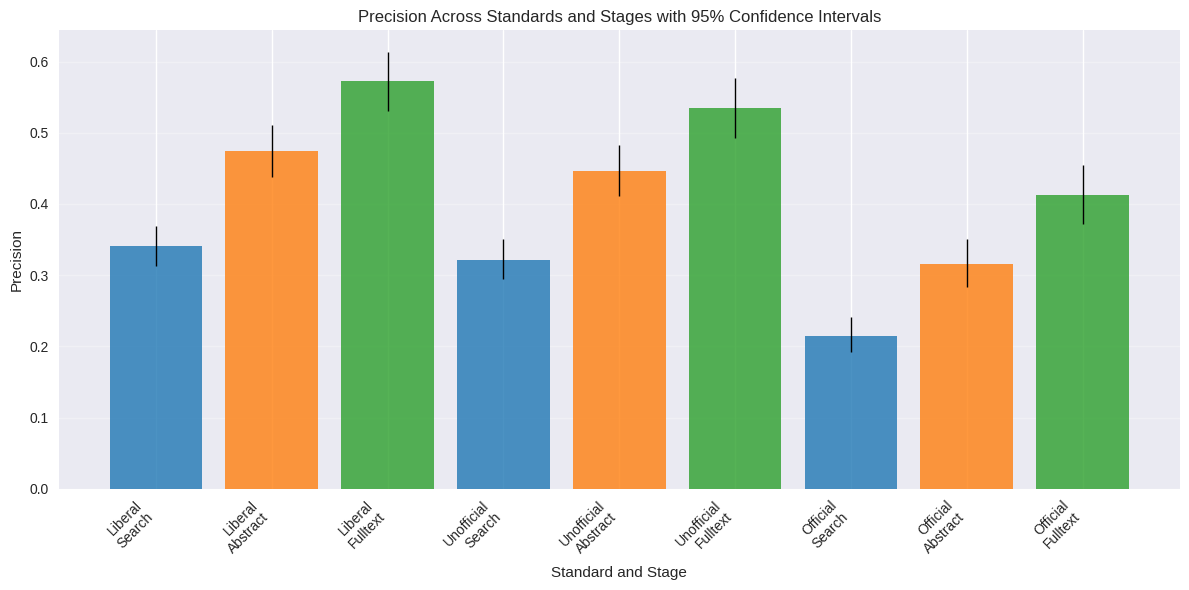

In [11]:
# Plot precision metrics
plot_metric_with_ci(df, "precision", 
                   "Precision Across Standards and Stages with 95% Confidence Intervals", 
                   "Precision")

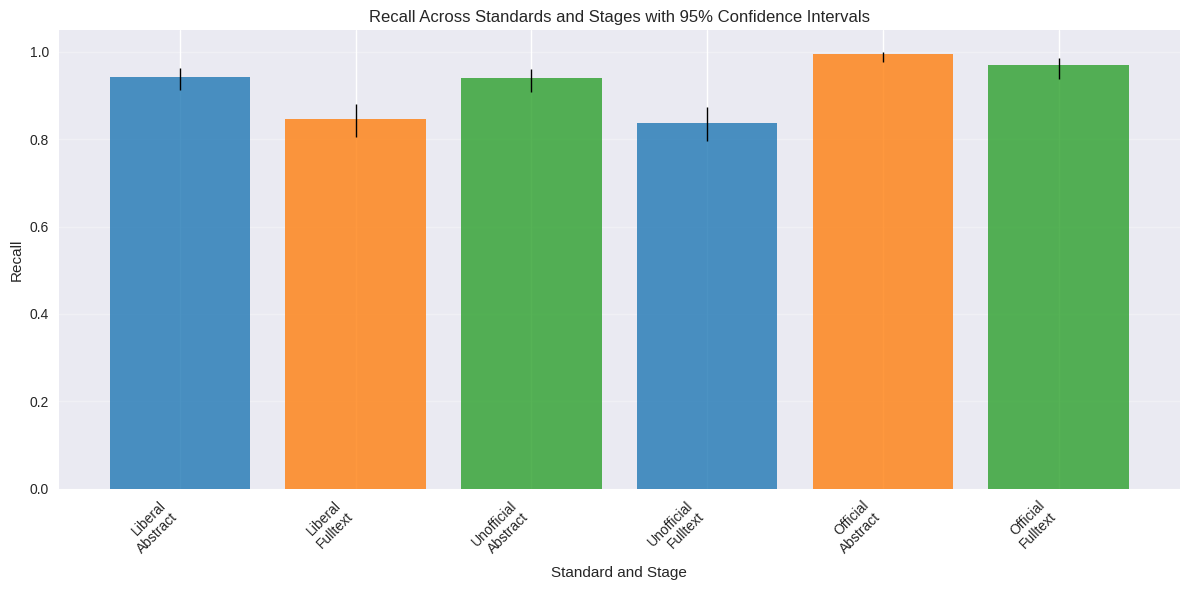

In [12]:
# Plot recall metrics
plot_metric_with_ci(df, "recall_all_meta", 
                   "Recall Across Standards and Stages with 95% Confidence Intervals", 
                   "Recall")

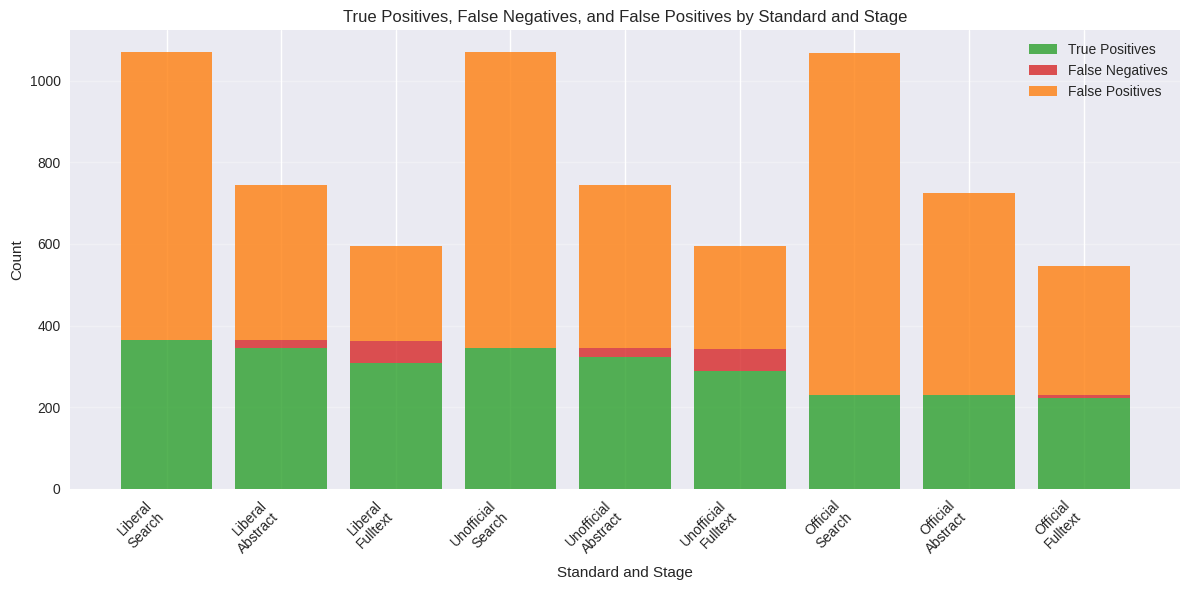

In [13]:
# Plot counts
plot_counts(df, ["true_positives", "false_negatives", "false_positives"], 
           "True Positives, False Negatives, and False Positives by Standard and Stage")

In [14]:
# Display summary table
print("Performance Summary Table")
print("="*50)

# Select key metrics for display
summary_cols = ["standard", "stage", "precision", "recall_all_meta", 
               "true_positives", "false_negatives", "false_positives"]
summary_df = df[summary_cols].copy()

# Format numeric columns
for col in ["precision", "recall_all_meta"]:
    summary_df[col] = summary_df[col].apply(lambda x: f"{x:.3f}" if pd.notna(x) else "N/A")

summary_df

Performance Summary Table


,standard,stage,precision,recall_all_meta,true_positives,false_negatives,false_positives
0,Liberal,Search,0.341,N/A,364,1,705
1,Liberal,Abstract,0.474,0.942,344,20,381
2,Liberal,Fulltext,0.572,0.847,309,54,231
3,Unofficial,Search,0.322,N/A,344,1,725
4,Unofficial,Abstract,0.447,0.939,324,20,401
5,Unofficial,Fulltext,0.535,0.838,289,54,251
6,Official,Search,0.215,N/A,230,0,839
7,Official,Abstract,0.316,0.996,229,1,496
8,Official,Fulltext,0.413,0.970,223,6,317


In [15]:
# Additional analysis: Compare standards at each stage
def compare_standards(df, stage):
    """Compare performance across standards for a specific stage"""
    stage_data = df[df['stage'] == stage.title()]
    
    print(f"\n{stage.title()} Stage Performance Comparison:")
    print("-" * 40)
    
    for _, row in stage_data.iterrows():
        print(f"{row['standard']} Standard:")
        print(f"  Precision: {row['precision']:.3f} (95% CI: {row['precision_ci_lower']:.3f} - {row['precision_ci_upper']:.3f})")
        print(f"  Recall: {row['recall_all_meta']:.3f} (95% CI: {row['recall_all_meta_ci_lower']:.3f} - {row['recall_all_meta_ci_upper']:.3f})")
        print(f"  TP: {row['true_positives']}, FN: {row['false_negatives']}, FP: {row['false_positives']}")
        print()

# Compare performance at each stage
for stage in stages:
    compare_standards(df, stage)


Search Stage Performance Comparison:
----------------------------------------
Liberal Standard:
  Precision: 0.341 (95% CI: 0.313 - 0.369)
  Recall: nan (95% CI: nan - nan)
  TP: 364, FN: 1, FP: 705

Unofficial Standard:
  Precision: 0.322 (95% CI: 0.294 - 0.350)
  Recall: nan (95% CI: nan - nan)
  TP: 344, FN: 1, FP: 725

Official Standard:
  Precision: 0.215 (95% CI: 0.192 - 0.241)
  Recall: nan (95% CI: nan - nan)
  TP: 230, FN: 0, FP: 839


Abstract Stage Performance Comparison:
----------------------------------------
Liberal Standard:
  Precision: 0.474 (95% CI: 0.438 - 0.511)
  Recall: 0.942 (95% CI: 0.914 - 0.962)
  TP: 344, FN: 20, FP: 381

Unofficial Standard:
  Precision: 0.447 (95% CI: 0.411 - 0.483)
  Recall: 0.939 (95% CI: 0.909 - 0.960)
  TP: 324, FN: 20, FP: 401

Official Standard:
  Precision: 0.316 (95% CI: 0.283 - 0.351)
  Recall: 0.996 (95% CI: 0.976 - 0.999)
  TP: 229, FN: 1, FP: 496


Fulltext Stage Performance Comparison:
----------------------------------------